In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

# --- 步骤 1: 数据加载与预处理 ---

# 设置matplotlib以支持中文显示
plt.rcParams['font.sans-serif'] = ['Kai']
plt.rcParams['axes.unicode_minus'] = False

# 加载WTI原油数据，处理缺失值
wti_df = pd.read_csv('RWTCd.csv', na_values='.')
# 仅保留日期和价格列，并重命名
wti_df = wti_df.iloc[:, :2]
wti_df.columns = ['Date', 'WTI_Price']
# **修正：根据用户提供的格式解析日期**
wti_df['Date'] = pd.to_datetime(wti_df['Date'], format='%b %d, %Y')
wti_df.set_index('Date', inplace=True)
wti_df.dropna(inplace=True)

# 加载布伦特原油数据，处理缺失值
brent_df = pd.read_csv('RBRTEd.csv', na_values='.')
# 仅保留日期和价格列，并重命名
brent_df = brent_df.iloc[:, :2]
brent_df.columns = ['Date', 'Brent_Price']
# **修正：根据用户提供的格式解析日期**
brent_df['Date'] = pd.to_datetime(brent_df['Date'], format='%b %d, %Y')
brent_df.set_index('Date', inplace=True)
brent_df.dropna(inplace=True)

# 通过内连接合并两个数据集，确保日期对齐
df = pd.merge(wti_df, brent_df, on='Date', how='inner')

# 使用 .loc 进行日期筛选，确保索引为日期格式
start_date = '2020-01-01'
end_date = '2025-6-30'
df = df.loc[start_date:end_date]

# 计算对数回报率（乘以100以提高数值稳定性）
df['WTI_Returns'] = 100 * np.log(df['WTI_Price']).diff()
df['Brent_Returns'] = 100 * np.log(df['Brent_Price']).diff()

# 删除因计算差分而产生的第一个空值行
df.dropna(inplace=True)

print("数据预览:")
print(df.head())
print("\n回报率统计描述:")
print(df[['WTI_Returns', 'Brent_Returns']].describe())

数据预览:
            WTI_Price  Brent_Price  WTI_Returns  Brent_Returns
Date                                                          
2020-01-03      63.00        69.08     2.947785       2.982664
2020-01-06      63.27        70.25     0.427656       1.679505
2020-01-07      62.70        68.74    -0.904984      -2.172904
2020-01-08      59.65        67.31    -4.986730      -2.102246
2020-01-09      59.56        66.58    -0.150994      -1.090458

回报率统计描述:
       WTI_Returns  Brent_Returns
count  1346.000000    1346.000000
mean      0.059495       0.058615
std       3.662343       3.296814
min     -28.138208     -25.638944
25%      -1.329739      -1.242004
50%       0.161098       0.172658
75%       1.549695       1.483328
max      42.583241      41.202251


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


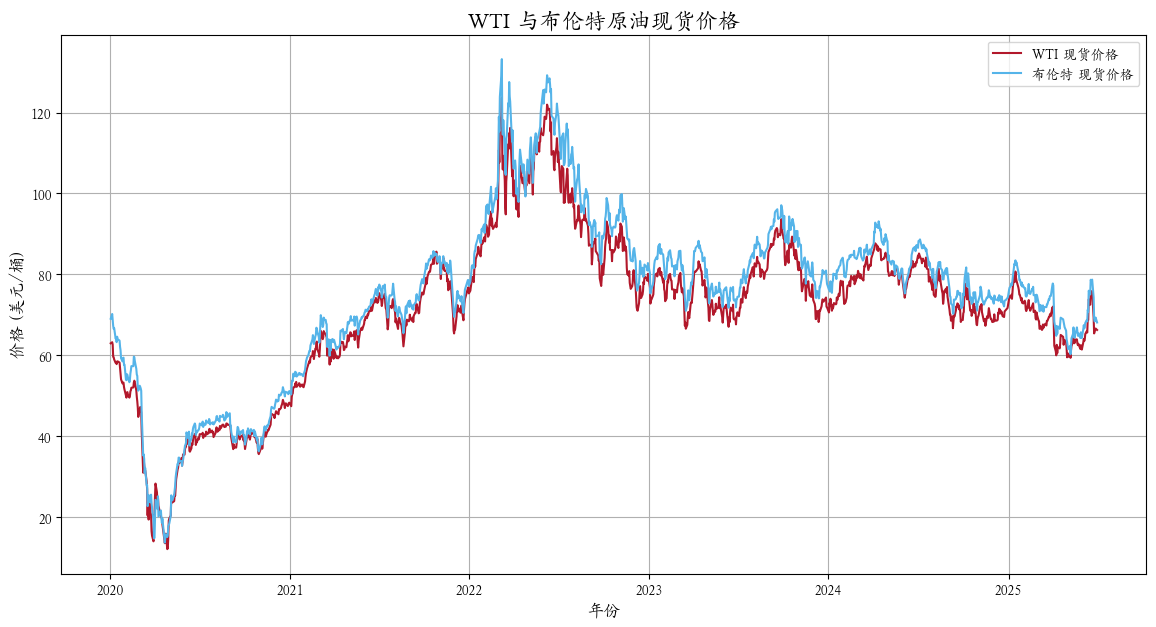

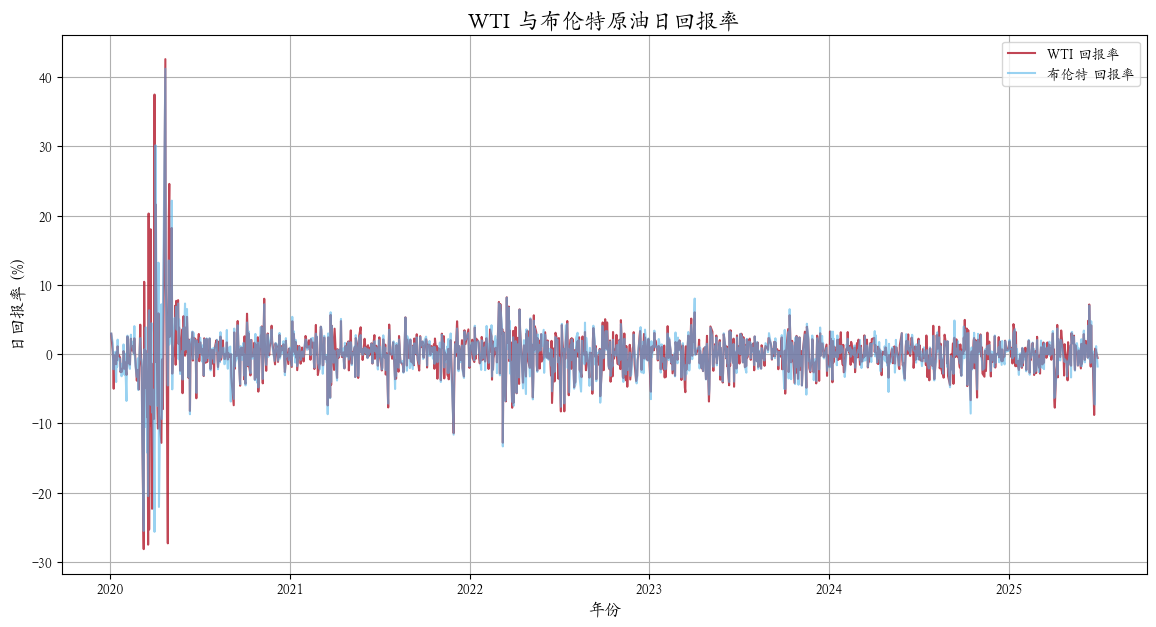

In [13]:
# --- 步骤 2: 可视化 ---

# 绘制价格走势图
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['WTI_Price'], label='WTI 现货价格', color='#b2182b')
plt.plot(df.index, df['Brent_Price'], label='布伦特 现货价格', color='#55b4e9')
plt.title('WTI 与布伦特原油现货价格', fontsize=16)
plt.xlabel('年份', fontsize=12)
plt.ylabel('价格 (美元/桶)', fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig('price_trends.png') # 保存图像
plt.show()


# 绘制回报率序列图
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['WTI_Returns'], label='WTI 回报率', color='#b2182b', alpha=0.8)
plt.plot(df.index, df['Brent_Returns'], label='布伦特 回报率', color='#55b4e9', alpha=0.6)
plt.title('WTI 与布伦特原油日回报率', fontsize=16)
plt.xlabel('年份', fontsize=12)
plt.ylabel('日回报率 (%)', fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig('returns_volatility_clustering.png') # 保存图像
plt.show()

In [9]:
# --- 步骤 3: 拟合模型 ---

def fit_volatility_models(returns, name):
    """
    一个辅助函数，用于拟合ARCH(1)和GARCH(1,1)模型并打印结果摘要。
    
    参数:
    returns (pd.Series): 回报率序列
    name (str): 序列的名称 (例如 'WTI' 或 'Brent')
    """
    print(f"--- 开始为 {name} 拟合模型 ---")
    
    # 拟合ARCH(1)模型
    # p=1, q=0 表示ARCH(1)
    arch_model_fit = arch_model(returns, vol='ARCH', p=1, q=0).fit(disp='off')
    print("\n--- ARCH(1) 模型拟合结果 ---")
    print(arch_model_fit.summary())
    
    # 拟合GARCH(1,1)模型
    # p=1, q=1 表示GARCH(1,1)
    garch_model_fit = arch_model(returns, vol='Garch', p=1, q=1).fit(disp='off')
    print(f"\n--- GARCH(1,1) 模型拟合结果 ---")
    print(garch_model_fit.summary())
    
    print(f"--- {name} 模型拟合结束 ---\n")
    return arch_model_fit, garch_model_fit

# 为WTI和布伦特拟合模型
wti_arch, wti_garch = fit_volatility_models(df['WTI_Returns'], 'WTI')
brent_arch, brent_garch = fit_volatility_models(df['Brent_Returns'], 'Brent')

--- 开始为 WTI 拟合模型 ---

--- ARCH(1) 模型拟合结果 ---
                      Constant Mean - ARCH Model Results                      
Dep. Variable:            WTI_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3344.58
Distribution:                  Normal   AIC:                           6695.17
Method:            Maximum Likelihood   BIC:                           6710.78
                                        No. Observations:                 1346
Date:                Wed, Oct 15 2025   Df Residuals:                     1345
Time:                        22:56:27   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0

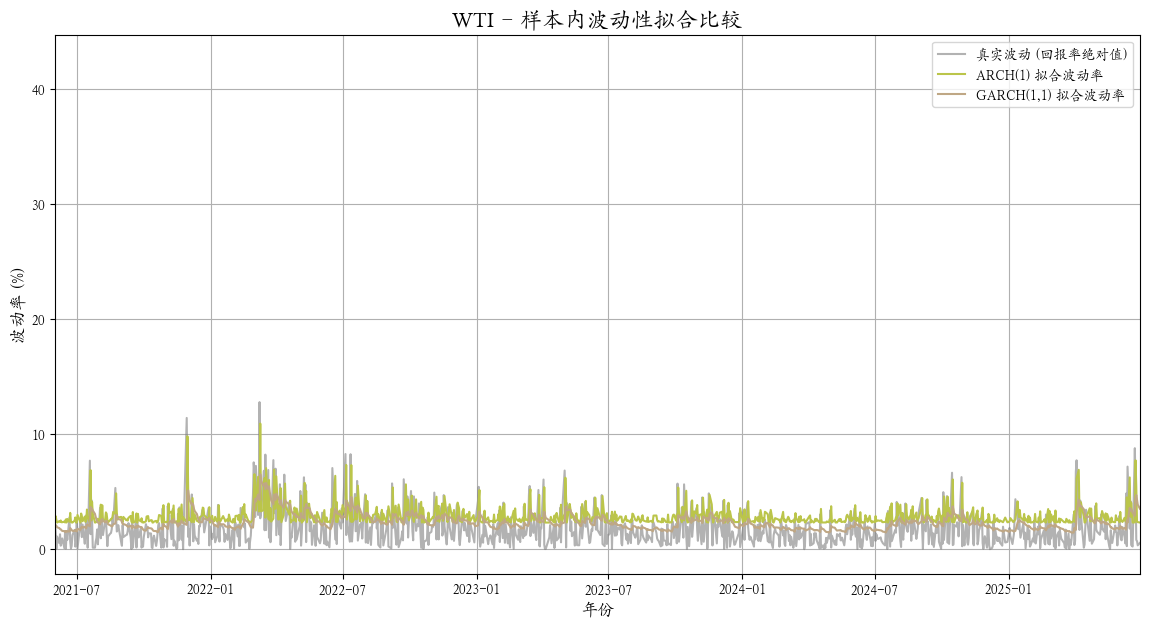

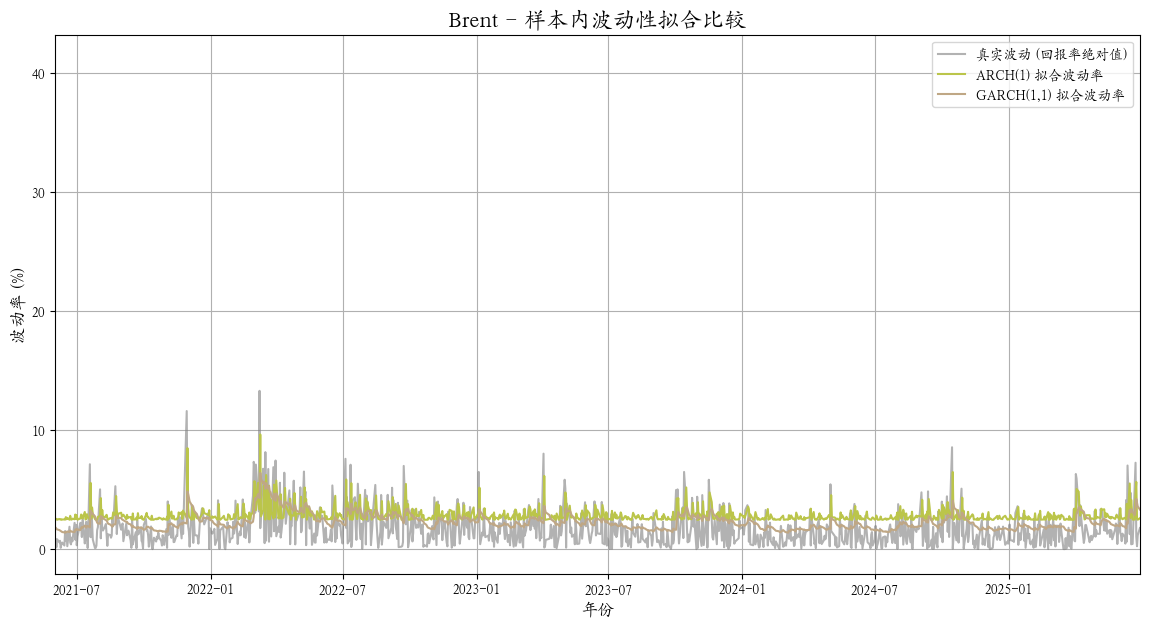

In [16]:
# --- 步骤 4: 样本内波动性比较 ---

def plot_in_sample_volatility(returns, arch_fit, garch_fit, name):
    """
    绘制样本内拟合的波动率与实际回报率的对比图。
    """
    # 提取拟合的条件波动率
    fitted_arch_vol = arch_fit.conditional_volatility
    fitted_garch_vol = garch_fit.conditional_volatility
    
    plt.figure(figsize=(14, 7))
    # 绘制回报率的绝对值作为真实波动的代理
    plt.plot(returns.index, returns.abs(), label='真实波动 (回报率绝对值)', color='grey', alpha=0.6)
    plt.plot(returns.index, fitted_arch_vol, label='ARCH(1) 拟合波动率', color='#bbc54a')
    plt.plot(returns.index, fitted_garch_vol, label='GARCH(1,1) 拟合波动率', color='#bfa785')
    
    plt.title(f'{name} - 样本内波动性拟合比较', fontsize=16)
    plt.xlabel('年份', fontsize=12)
    plt.ylabel('波动率 (%)', fontsize=12)
    plt.legend()
    plt.grid(True)
    # 限制显示范围，以便更清晰地查看最近1000个交易日的情况
    plt.xlim([returns.index[-1000], returns.index[-1]])
    plt.savefig(f'{name}_in_sample_vol.png')
    plt.show()


# 为WTI和布伦特绘制样本内波动率图
plot_in_sample_volatility(df['WTI_Returns'], wti_arch, wti_garch, 'WTI')
plot_in_sample_volatility(df['Brent_Returns'], brent_arch, brent_garch, 'Brent')

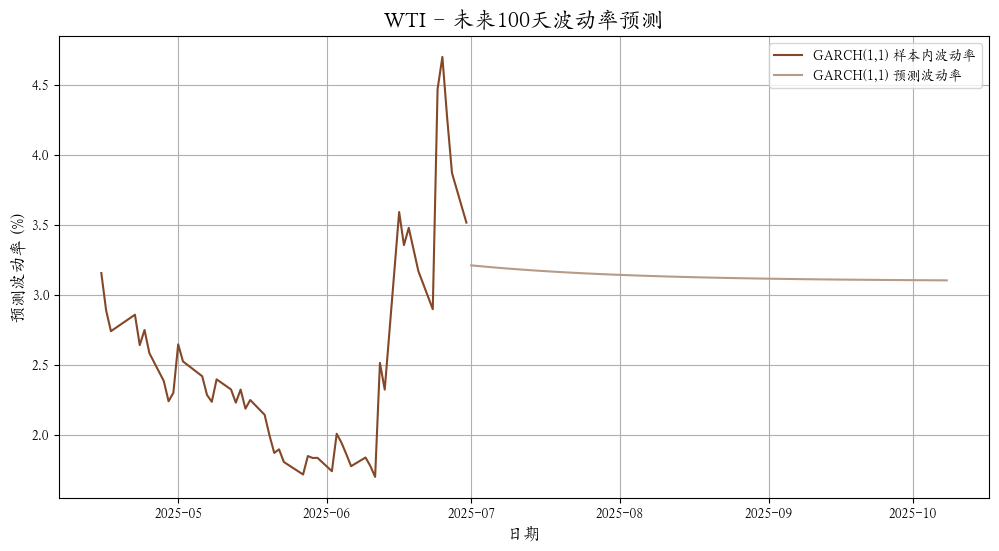

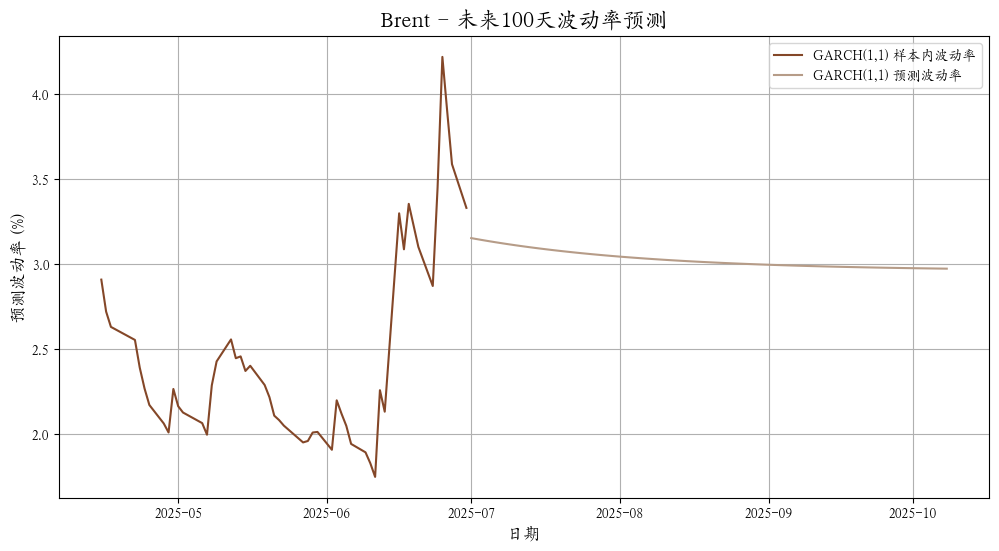

In [18]:
# --- 步骤 5: 波动性预测 ---

def forecast_volatility(garch_fit, returns, name, n_forecast=100):
    """
    使用GARCH(1,1)模型预测未来波动率并绘图。
    """
    # 获取最后50个样本点用于绘图上下文
    last_n = 50
    
    # 进行预测
    forecast = garch_fit.forecast(horizon=n_forecast, reindex=False)
    # 预测的方差，需要开根号得到波动率
    forecast_vol = np.sqrt(forecast.variance.iloc[0])
    
    # 创建未来的日期索引
    future_dates = pd.date_range(returns.index[-1] + pd.Timedelta(days=1), periods=n_forecast)
    
    # 绘制
    plt.figure(figsize=(12, 6))
    # 绘制历史样本内波动率
    plt.plot(returns.index[-last_n:], garch_fit.conditional_volatility[-last_n:], label='GARCH(1,1) 样本内波动率', color='#844728')
    # 绘制预测的波动率
    plt.plot(future_dates, forecast_vol, label='GARCH(1,1) 预测波动率', color='#b69c88')
    
    plt.title(f'{name} - 未来100天波动率预测', fontsize=16)
    plt.xlabel('日期', fontsize=12)
    plt.ylabel('预测波动率 (%)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{name}_volatility_forecast.png')
    plt.show()


# 对WTI和布伦特进行预测
forecast_volatility(wti_garch, df['WTI_Returns'], 'WTI')
forecast_volatility(brent_garch, df['Brent_Returns'], 'Brent')